<a href="https://colab.research.google.com/github/RoshanChongder/IMAGE-PROCESSING-AND-FACIAL-EMOTION-DETECTION/blob/master/confusionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First , we will load the trained model 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import the required libraries 
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2 , os , time , html 
import numpy as np
import PIL , io
from keras.preprocessing import image
from keras.models import model_from_json 

In [ ]:
#drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/
model = model_from_json( open('drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/fer.json','r').read() )
# drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/
model.load_weights( 'drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/fer.h5' )
print('The model is been loadded with weights')

The model is been loadded with weights


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 64)         

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img


def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png') # format bbox into png for return
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))  # format return string

  return bbox_bytes
  

In [ ]:
# Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:

def take_photo( loc , quality=0.8 ):

  ''' This method receives a location of an image .
  Then it reads the image and then predicts the emotion of 
  the face present in the image ''' 


  # read the image from the drive location that is passed 
  img = cv2.imread( loc , cv2.IMREAD_COLOR )
  
  # convertion to grayscale 
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #print(gray_img.shape)

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray_img)
  
  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)
  
  predicted = []

  # draw face bounding box on image
  for (x,y,w,h) in faces:

      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # placing the rectangle around the face 
      cropped_gray = gray_img[y:y+w,x:x+h]  # cropping the face from the image 
      cropped_gray = cv2.resize(cropped_gray,(48,48)) # resizing the image 
      img_pixels = image.img_to_array(cropped_gray)  # getting the image pixeles into array 
      img_pixels = np.expand_dims(img_pixels, axis = 0) # expanding dim 
      img_pixels /= 255

      predictions = model.predict(img_pixels)  # predicting 
        #print( predictions )
        #find max indexed array
      index = np.argmax(predictions[0]) 
        
      emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
      predicted_emotion = emotions[index]  
      predicted.append( index  )
      #print( predicted_emotion )
      cv2.putText( img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
 
  return [ img , predicted ] 

In [ ]:
# from where all the images will be read 
directory = 'drive/MyDrive/EmotionDetection/Model_Training_Op/images'   

# d is for directory refference and tag  
# actual and pre will store actual emotion and predicted emotion 
d , actual , pre = { "angry" : 0 , "happy" : 3 , "sad" : 4 , "surprise" : 5 , "neutral" : 6 } , [] , [] 

for dir in os.listdir(directory) : 
  tag = None 
  
  if dir in d :
    tag = d[dir]  # getting the tag correspondin to the dir  
  else :
    print( dir , " not found in " , d )
    break 

  subdir = os.path.join( directory, dir ) # selecting a certain sub-directory 
  print( "Processing the direcotry : " , subdir , "\n\n")

  for files in os.listdir(subdir) :
    try :
      name = os.path.join( subdir , files ) # name of the file 
      if os.path.isfile( name ):
        img , predicted = take_photo( name )  # calling take with image location in drive  
        if len(predicted) != 0 :
          print( "Actual " , tag , "Predicted value " , predicted )  # printing the predicted value
          actual.append(tag) # for debugging 
          pre.append(  tag if ( tag in predicted ) else predicted[0]  )
          print(actual[-1] , pre[-1]) # for debugging 
          cv2.imwrite( subdir + "/predicted/" + files , img  ) 
        else :
          print("Model not able to predict for " , name )
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

print(actual , pre )
 

Processing the direcotry :  drive/MyDrive/EmotionDetection/Model_Training_Op/images/happy 


Actual  3 Predicted value  [3, 4]
3 3
Actual  3 Predicted value  [3, 6]
3 3
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3, 6]
3 3
Actual  3 Predicted value  [0]
3 0
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3]
3 3
Model not able to predict for  drive/MyDrive/EmotionDetection/Model_Training_Op/images/happy/happy9.jpg
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3, 6, 6, 6, 0, 6, 3, 6]
3 3
Actual  3 Predicted value  [3, 6]
3 3
Actual  3 Predicted value  [3, 4]
3 3
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [6]
3 6
Actual  3 Predicted value  [3]
3 3
Actual  3 Predicted value  [3]
3 3
Processing the direcotry :  drive/MyDrive/EmotionDetection/Model_Training_Op/images/angry 


Actual  0

In [ ]:
print(actual)
print(pre)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 0, 0, 6, 6, 0, 0, 0, 6, 0, 3, 4, 6, 0, 4, 4, 4, 6, 3, 4, 6, 4, 3, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 0, 3, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6]


In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt  
import itertools 
from sklearn.metrics import confusion_matrix

In [ ]:
c_matrix = confusion_matrix(y_true = actual , y_pred = pre )

In [ ]:
def plot_confusion_matrix( cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_labels = ['angry', 'happy', 'sad', 'surprise', 'neutral']
print(type(c_matrix))

<class 'numpy.ndarray'>


Confusion matrix, without normalization
[[ 7  1  1  0  4]
 [ 1 17  0  0  1]
 [ 0  2 10  0  2]
 [ 0  0  0  5  4]
 [ 1  1  1  1 15]]


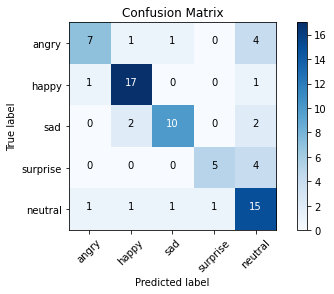

In [ ]:
plot_confusion_matrix( cm = c_matrix , classes = plot_labels , title='Confusion Matrix' )

In [ ]:
print(c_matrix)

[[ 7  1  1  0  4]
 [ 1 17  0  0  1]
 [ 0  2 10  0  2]
 [ 0  0  0  5  4]
 [ 1  1  1  1 15]]


In [ ]:
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import accuracy_score

# lambda method for main 4 terms - TP , TN , FP and FN 
TruePositive = lambda conf_mat : sum( [ conf_mat[i][i] for i in range(len(conf_mat)) ] )
TrueNegative = TruePositive   # as both will be the same case 
FalsePositive = lambda conf_mat : sum( [ conf_mat[i][j] for i in range(len(conf_mat))  for j in range(len(conf_mat)) ] ) - TruePositive(conf_mat)
FalseNegative = FalsePositive # as both will be the same cse 
TotalSample = lambda conf_mat : sum( [ conf_mat[i][j] for i in range(len(conf_mat))  for j in range(len(conf_mat)) ] )

print( "True Positive : " , TruePositive(c_matrix) , "\nTrue Negative : " , TrueNegative(c_matrix) )
print( "False Positive : " , FalsePositive(c_matrix) , "\nFalse Negative : " , FalseNegative(c_matrix) )
print( "Total Sample : " , TotalSample(c_matrix)  )

# precession - sum of tp accross all class / sum of ( TP and FN across all class)
# precession - TP / ( TP + FN )
precession = TruePositive(c_matrix) / ( TruePositive(c_matrix) + FalseNegative(c_matrix) )
print("Precession " , precession )
#print( precision_score( actual, pre , average = 'micro' ) )



# recall - sum of tp accross all class / sum of ( TP and FN across all class)
# recall - TP / ( TP + FN )
recall = TruePositive(c_matrix) / ( TruePositive(c_matrix) + FalseNegative(c_matrix) )
print("Recall " , precession )
#print( recall_score( actual, pre , average = 'micro' ) )


# F2 score - (5*precession*recall) / (4*precession+recall) 
f2_score = (5*precession*recall) / (4*precession+recall) 
print("F2 score " , f2_score )
#print( fbeta_score(actual, pre , beta = 2.0 , average = 'micro' ) )


# accuracy 
accuracy = TruePositive(c_matrix) / TotalSample(c_matrix) 
print('Accuracy : ' , accuracy )
#print( accuracy_score( actual, pre ) )


True Positive :  54 
True Negative :  54
False Positive :  20 
False Negative :  20
Total Sample :  74
Precession  0.7297297297297297
0.7297297297297297
Recall  0.7297297297297297
0.7297297297297297
F2 score  0.7297297297297297
0.7297297297297297
Accuracy :  0.7297297297297297
0.7297297297297297


Plotting confusion matrix in percentage form 

Confusion matrix, without normalization
[[0.54 0.08 0.08 0.   0.31]
 [0.05 0.89 0.   0.   0.05]
 [0.   0.14 0.71 0.   0.14]
 [0.   0.   0.   0.56 0.44]
 [0.05 0.05 0.05 0.05 0.79]]


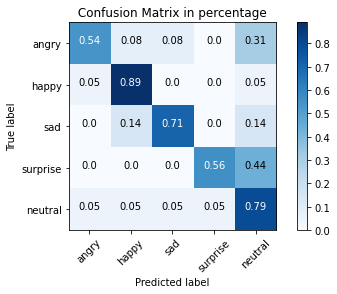

In [ ]:
# this can also be done using the sklearn library 
def percent_confusion_matrix( cm ) :
  pcm = []   # confusion matrix in percentage 
  for i in cm :
    total_images , temp = sum(i) , [] 
    for j in i :
      temp.append(round(j/total_images , 2 ) )
    pcm.append(temp)
  return pcm
plot_confusion_matrix( cm = np.array(percent_confusion_matrix(c_matrix)) , classes = plot_labels , title=' Confusion Matrix in percentage ' )

Computing the same using sklearn 

In [ ]:
nc_matrix = confusion_matrix( y_true = actual , y_pred = pre , normalize = 'true' )
print(nc_matrix)

[[0.53846154 0.07692308 0.07692308 0.         0.30769231]
 [0.05263158 0.89473684 0.         0.         0.05263158]
 [0.         0.14285714 0.71428571 0.         0.14285714]
 [0.         0.         0.         0.55555556 0.44444444]
 [0.05263158 0.05263158 0.05263158 0.05263158 0.78947368]]
